In [170]:
# Titanic Challenge - EDA Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

# Load training and test data
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# Display basic structure
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

#Lets print the data to see how it looks 
print(train_df.columns)
train_df.head()




Train shape: (891, 12)
Test shape: (418, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Column       | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| PassengerId  | Unique ID for each passenger (just a row index)                             |
| Survived     | Survival indicator: 1 = survived, 0 = did not survive                       |
| Pclass       | Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd). A proxy for socioeconomic status |
| Name         | Full name, often includes title (e.g., Mr., Mrs., Miss). Useful for extracting Title |
| Sex          | Gender: male or female                                                      |
| Age          | Age in years. Some missing values. Can be binned or imputed                 |
| SibSp        | Number of siblings or spouses aboard the Titanic                            |
| Parch        | Number of parents or children aboard                                        |
| Ticket       | Ticket number. Can contain letters and numbers — sometimes useful for group detection |
| Fare         | Ticket price paid (float)                                                   |
| Cabin        | Cabin number. Many missing values. Can extract deck (e.g., "C85" → deck C)  |
| Embarked     | Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton         |


In [120]:
# lets havea look how many NaN there are in each column
columns = train_df.columns
for col in columns:
    print('In {} there are {} NaNs'.format(col, train_df[col].isna().sum()))


In PassengerId there are 0 NaNs
In Survived there are 0 NaNs
In Pclass there are 0 NaNs
In Name there are 0 NaNs
In Sex there are 0 NaNs
In Age there are 177 NaNs
In SibSp there are 0 NaNs
In Parch there are 0 NaNs
In Ticket there are 0 NaNs
In Fare there are 0 NaNs
In Cabin there are 687 NaNs
In Embarked there are 2 NaNs


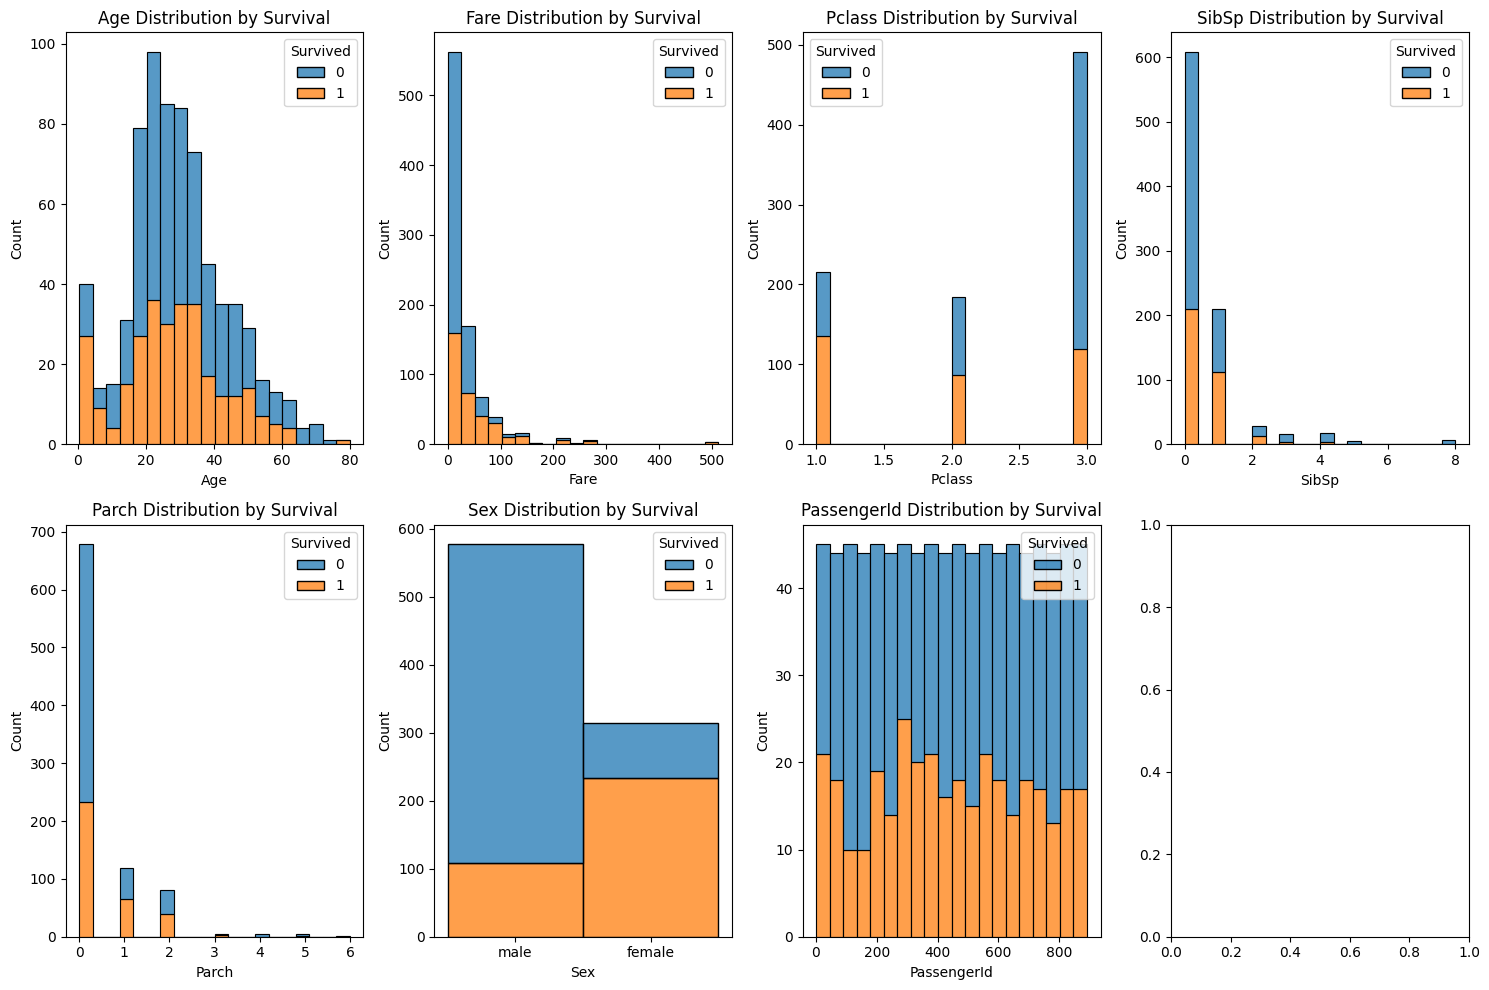

In [119]:
# lets make some histogram plots showing the hue of survival rate over differnt dimensions
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax = ax.flatten()

# Pick 6 features you want to explore
columns = ["Age", "Fare", "Pclass", "SibSp", "Parch", "Sex", "PassengerId"]

for i, col in enumerate(columns):
    sns.histplot(data=train_df, x=col, bins=20, hue="Survived", multiple="stack", ax=ax[i])
    ax[i].set_title(f"{col} Distribution by Survival")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Count")


plt.tight_layout()
plt.show()


In [ ]:
# Preprocess 
features = ["Pclass", "Age", "SibSp", "Parch", "Fare", 'Sex', 'Family_size', 'Status', 'Embarked', 'Deck', 'Room', 'Ticket', 'VIP']

#fill the remaining NaN with the average of the ages 
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())
train_df["Fare"] = train_df["Fare"].fillna(train_df["Fare"].mean())


test_df["Age"] = test_df["Age"].fillna(train_df["Age"].mean())
test_df["Fare"] = test_df["Fare"].fillna(train_df["Fare"].mean())

train_df["VIP"]  = train_df["Pclass"] * train_df["Fare"] 
test_df["VIP"]  = test_df["Pclass"] * test_df["Fare"] 

train_df["Ticket"] = train_df["Ticket"].str.extract(r'(\d+)').fillna(0)
test_df["Ticket"] = test_df["Ticket"].str.extract(r'(\d+)').fillna(0)

train_df['Sex'] = train_df['Sex'].map({'male':1, 'female':0})
test_df['Sex'] = test_df['Sex'].map({'male':1, 'female':0})

train_df['Family_size'] = train_df['SibSp']  + train_df['Parch'] + 1
test_df['Family_size'] = test_df['SibSp']  + test_df['Parch'] + 1

# function to check status
def check_status(df):
    status = []
    for name in df['Name']:
        if 'Mr.' in name:
            status.append(1)
        elif 'Mrs.' in name: 
            status.append(2)
        elif 'Miss.' in name:
            status.append(3)
        elif 'Rev.' in name:
            status.append(4)
        elif 'Master.' in name:
            status.append(5)
        elif 'Major.' in name:
            status.append(6)
        else:
            status.append(0)
    return status

train_df['Status'] = check_status(train_df)
test_df['Status'] = check_status(test_df)

#Extract Deck and room (for ticket with multiple rooms, jsut considering the lsat room, filling NaN with zeros)
def get_deck_room(df):
    dict_room_deck = {'Deck': [], 'Room': [] } ## TODO: is ALone feature 
    for row in df['Cabin']:
        if isinstance(row, str):
            if len(row) <=4: 
                if len(row) < 2:
                    dict_room_deck['Deck'].append(ord(row[0]))
                    dict_room_deck['Room'].append(0)
                else:
                    dict_room_deck['Deck'].append(ord(row[0]))
                    dict_room_deck['Room'].append(int(row[1:]))
            else:
                try: 
                    number = int(row)
                    if number:
                        dict_room_deck['Deck'].append(0)
                        dict_room_deck['Room'].append(number)

                except:
                    row_split = re.split(' ', row)[-1]
                    dict_room_deck['Deck'].append(ord(row_split[0]))
                    dict_room_deck['Room'].append(int(row_split[1:]))

        else:
            dict_room_deck['Deck'].append(0)
            dict_room_deck['Room'].append(0)
     
    return pd.DataFrame(dict_room_deck)

train_df = pd.concat([train_df.reset_index(drop=True), get_deck_room(train_df).reset_index(drop=True)], axis = 1)
test_df = pd.concat([test_df.reset_index(drop=True), get_deck_room(test_df).reset_index(drop=True)], axis = 1)

#Unique labels for embarked ['S', 'C', 'Q', nan]
train_df['Embarked'] = train_df['Embarked'].map({'S':1, 'C':2, 'Q':3})
train_df['Embarked'] = train_df['Embarked'].fillna(0)

test_df['Embarked'] = test_df['Embarked'].map({'S':1, 'C':2, 'Q':3})
test_df['Embarked'] = test_df['Embarked'].fillna(0)




from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca_train = pca.fit_transform(train_df[features])
X_pca_test = pca.transform(test_df[features])

# Add PCA components
X_pca_train = pd.DataFrame(X_pca_train, columns=["PC1"])
X_pca_test = pd.DataFrame(X_pca_test, columns=["PC1"])

# Combine original + PCA
train_df = pd.concat([train_df.reset_index(drop=True), X_pca_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), X_pca_test.reset_index(drop=True)], axis=1)

features = features + ["PC1"]

In [172]:
#Show the data after pre processing and cleaning 
train_df[features]

,Pclass,Age,SibSp,Parch,Fare,Sex,Family_size,Status,Embarked,Deck,Room,Ticket,VIP,PC1
0,3,22.000000,1,0,7.2500,1,2,1,1.0,0,0,5,21.7500,-226818.514263
1,1,38.000000,1,0,71.2833,0,2,2,2.0,67,85,17599,71.2833,-209224.516857
2,3,26.000000,0,0,7.9250,0,1,3,1.0,0,0,2,23.7750,-226821.514301
3,1,35.000000,1,0,53.1000,0,2,2,1.0,67,123,113803,53.1000,-113020.516740
4,3,35.000000,0,0,8.0500,1,1,1,1.0,0,0,373450,24.1500,146626.485590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,1,1,4,1.0,0,0,211536,26.0000,-15287.514435
887,1,19.000000,0,0,30.0000,0,1,3,1.0,66,42,112053,30.0000,-114770.515598
888,3,29.699118,1,2,23.4500,0,4,3,1.0,0,0,6607,70.3500,-220216.514912
889,1,26.000000,0,0,30.0000,1,1,1,2.0,67,148,111369,30.0000,-115454.516386


ACCURACY = 0.8324022346368715


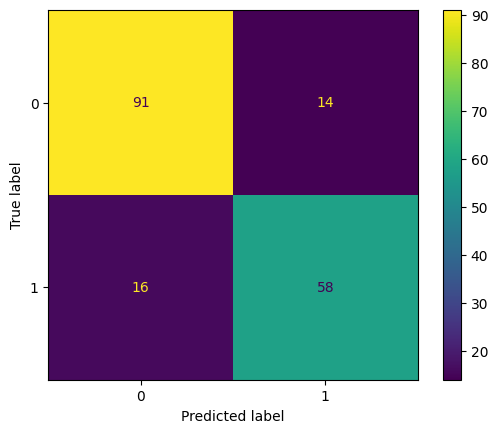

In [180]:
# lets implement a very quick RandomForest classifier 
# First we need to pre procees the data, meaning that we keep thecolumns we want to use and clean it fro many NaNs
# In this case we will use the target to be the Survival 0 or 1 
# For the trianing we will use the following columns for now: PassengerId	Pclass	Age	SibSp	Parch	Fare

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import sklearn


df = train_df[["Survived"] + features].dropna()

X = df[features]
y = df["Survived"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print('ACCURACY = {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))

In [178]:
# Now we get the testign data nad prep it for validation: 
test_data = test_df[features]

# lets remove all NaNs for now
test_data = test_data.dropna()
test_data = test_data[features]
testing_data = scaler.transform(test_data)

# now we see the first predition: 
predicted = clf.predict(testing_data)

#prediction submission: 
sub = {'PassengerId':test_df[features + ["PassengerId"]].dropna()["PassengerId"] , 'Survived': predicted}
sub = pd.DataFrame(sub)
sub


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [175]:
# lets go a bit indepth: lets try various differnt classifiers
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm 

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42)
]

r2_scores = []
accuracy = []

for i, name in tqdm(enumerate(names)):
    clf = classifiers[i].fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    r2_scores.append(sklearn.metrics.r2_score(y_test, y_pred))
    accuracy.append(sklearn.metrics.accuracy_score(y_test, y_pred))


8it [00:23,  2.96s/it]


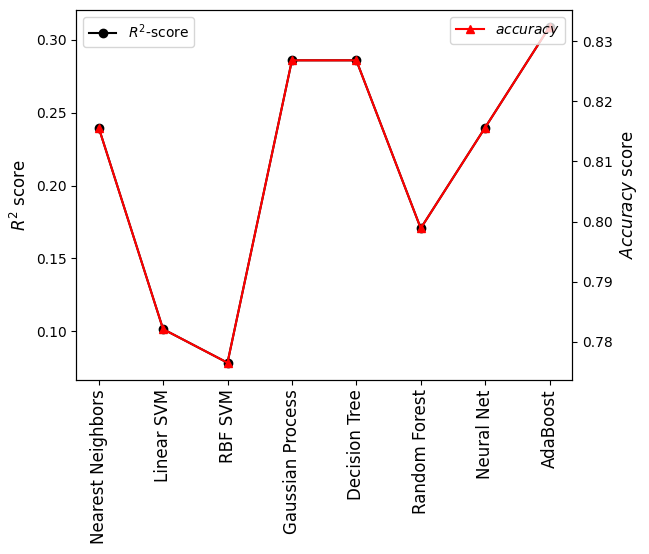

In [176]:
import numpy as np
fig, ax1 = plt.subplots() 
x = np.arange(0, len(names))

ax1.plot(r2_scores, '-ok', label = '$R^{2}$-score')
ax1.set_ylabel(r'$R^{2}$ score', fontsize = 12)

ax2 = ax1.twinx() 
ax2.plot(accuracy, '-^r', label = '$accuracy$')
ax1.set_xticks(x, names, fontsize = 12, rotation=90)
ax2.set_ylabel(r'$Accuracy$ score', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')




In [ ]:
from here we find that nearest neighbors algorithm has produced the best resutls, and thus 